In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def train_unpaired(model_rna, model_atac, disc, data_loader_rna, data_loader_atac, diff_sim_rna, 
                   diff_sim_atac, optimizer_rna, optimizer_atac, optimizer_D, n_epochs = 50, 
                   n_iter = 15, lamb_r_rna = 1, lamb_r_atac = 1, lamb_disc = 1):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for epoch in range(n_epochs):
        # iteration = zip(data_loader_rna, cycle(data_loader_atac)) if len(data_loader_rna) > len(data_loader_atac) else zip(cycle(data_loader_rna), data_loader_atac)
        iteration = zip(data_loader_rna, data_loader_atac)
        for data in iteration:
            # Update RNA Encoder
            data_rna, data_atac = data
            batch_cols_rna = data_rna['index'].to(device)
            batch_sim_rna = diff_sim_rna[batch_cols_rna,:][:,batch_cols_rna]
            batch_expr_rna = data_rna['count'].to(device)

            batch_expr_r_rna = model_rna(batch_expr_rna)
            z_rna = model_rna[:1](batch_expr_rna)
#             traj_loss(recon_x, x, z, diff_sim, lamb_recon = 1, lamb_dist = 1, recon_mode = "original")
            train_loss_rna, loss_recon_rna, loss_dist_rna = traj_loss(recon_x = batch_expr_r_rna, x = batch_expr_rna, z = z_rna, diff_sim = batch_sim_rna, lamb_recon = lamb_r_rna, lamb_dist = 1, recon_mode = "relative")

            train_loss_rna.backward()
            optimizer_rna.step()
            optimizer_rna.zero_grad()

            # Update ATAC Encoder
            batch_cols_atac = data_atac['index'].to(device)
            batch_sim_atac = diff_sim_atac[batch_cols_atac,:][:,batch_cols_atac]
            batch_expr_atac = data_atac['count'].to(device)

            batch_expr_r_atac = model_atac(batch_expr_atac)
            z_atac = model_atac[:1](batch_expr_atac)

            train_loss_atac, loss_recon_atac, loss_dist_atac = traj_loss(recon_x = batch_expr_r_atac, x = batch_expr_atac, z = z_atac, diff_sim = batch_sim_atac, lamb_recon = lamb_r_atac, lamb_dist = 1, recon_mode = "relative")

            train_loss_atac.backward()
            optimizer_atac.step()
            optimizer_atac.zero_grad()

            # need to go through all the calculation again since the encoder has been updated, ERROR shows up in pytorch 1.5 and above.
            # see: https://github.com/pytorch/pytorch/issues/39141 
            z_rna = model_rna[:1](batch_expr_rna)
            z_atac = model_atac[:1](batch_expr_atac)

            # Update Discriminator
            D_loss_avg = 0
            n_rna = batch_cols_rna.shape[0]
            n_atac = batch_cols_atac.shape[0]
            # note that detach here is necessary, use directly will cause error in encoder update later
            input_disc = torch.cat((z_rna.detach(), z_atac.detach()), dim = 0)
            target = torch.cat((torch.full((n_rna, ), 0, dtype = torch.float), torch.full((n_atac, ), 1, dtype = torch.float))).to(device)
            

            for i in range(n_iter):
                output = disc(input_disc).squeeze()
                D_loss = lamb_disc * F.binary_cross_entropy(output, target)
                D_loss_avg += D_loss.item()
                D_loss.backward()
                optimizer_D.step()
                optimizer_D.zero_grad()
            D_loss_avg /= n_iter

            # Update Encoder
            E_loss = -lamb_disc * F.binary_cross_entropy(disc(torch.cat((z_rna, z_atac), dim = 0)).squeeze(), target)
            E_loss.backward()
            optimizer_rna.step()
            optimizer_atac.step()
            optimizer_rna.zero_grad()
            optimizer_atac.zero_grad()

        if epoch % 10 == 0:
            log_rna = "RNA loss: {:.5f}, RNA recon loss: {:.5f}, RNA dist loss: {:.5f}".format(train_loss_rna.item(), loss_recon_rna.item(), loss_dist_rna.item())
            log_atac = "ATAC loss: {:.5f}, ATAC recon loss: {:.5f}, ATAC dist loss: {:.5f}".format(train_loss_atac.item(), loss_recon_atac.item(), loss_dist_atac.item())
            log_D = "Discriminator loss: {:.5f}".format(D_loss_avg)
            print("epoch: ", epoch, log_rna, log_atac, log_D)

In [34]:
symsim_r1b1 = endoRNA_noIAC(standardize=False)
symsim_r1b2 = endoATAC_noIAC(standardize=False)

symsim_r1b1_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

symsim_r1b2_CONFIG = { 
    'in_features': 128,
    'layers': [256, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_r1b2_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 10, 
                                  t = 20, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 40)

    Diff1 = torch.FloatTensor(Diff1).to(device)
    


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 10, 
                                  t = 100, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 70)
    

    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    

In [45]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
      ])).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 5e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 5e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 5e-4)

In [46]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, n_epochs=151, n_iter=30, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=1)

epoch:  0 RNA loss: -0.93962, RNA recon loss: 0.00000, RNA dist loss: -0.93962 ATAC loss: -0.95058, ATAC recon loss: 0.00000, ATAC dist loss: -0.95058 Discriminator loss: 0.49553
epoch:  10 RNA loss: -0.98351, RNA recon loss: 0.00000, RNA dist loss: -0.98351 ATAC loss: -0.99298, ATAC recon loss: 0.00000, ATAC dist loss: -0.99298 Discriminator loss: 0.51509
epoch:  20 RNA loss: -0.98951, RNA recon loss: 0.00000, RNA dist loss: -0.98951 ATAC loss: -0.92965, ATAC recon loss: 0.00000, ATAC dist loss: -0.92965 Discriminator loss: 0.55078
epoch:  30 RNA loss: -0.97761, RNA recon loss: 0.00000, RNA dist loss: -0.97761 ATAC loss: -0.99778, ATAC recon loss: 0.00000, ATAC dist loss: -0.99778 Discriminator loss: 0.62813
epoch:  40 RNA loss: -0.99413, RNA recon loss: 0.00000, RNA dist loss: -0.99413 ATAC loss: -0.99553, ATAC recon loss: 0.00000, ATAC dist loss: -0.99553 Discriminator loss: 0.65678
epoch:  50 RNA loss: -0.99297, RNA recon loss: 0.00000, RNA dist loss: -0.99297 ATAC loss: -0.97383, 

In [51]:
# torch.save({
#     'ae1': ae1.state_dict(),
#     'optim_ae1': optimizer_rna.state_dict(),
#     'ae2': ae2.state_dict(),
#     'optim_ae2': optimizer_rna.state_dict(),
#     'disc': disc.state_dict(),
#     'optim_disc': optimizer_D.state_dict(),
#     'config1': symsim_r1b1_CONFIG,
#     'config2': symsim_r1b2_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/endo_phate_new.pt')

In [48]:
# state = torch.load('./saved_model/endo_phate_test.pt')

# ae1 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
#       ])).to(device)
# ae1.load_state_dict(state['ae1'])

# ae2 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
#       ])).to(device)
# ae2.load_state_dict(state['ae2'])

# disc = ae.discriminator().to(device)
# disc.load_state_dict(state['disc'])

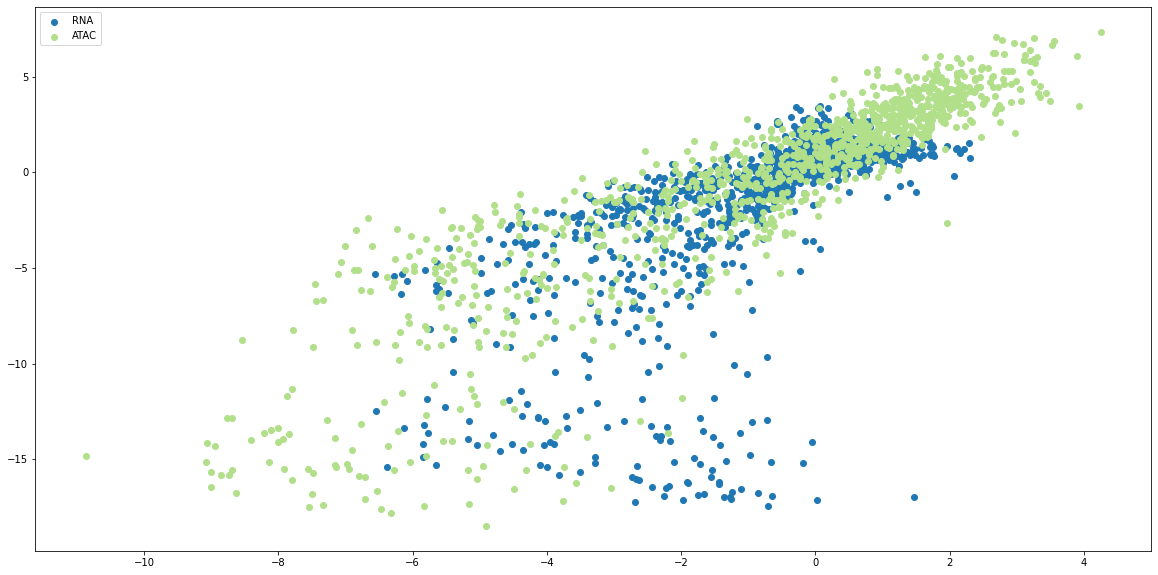

In [54]:
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = "result/endo/modality.pdf")


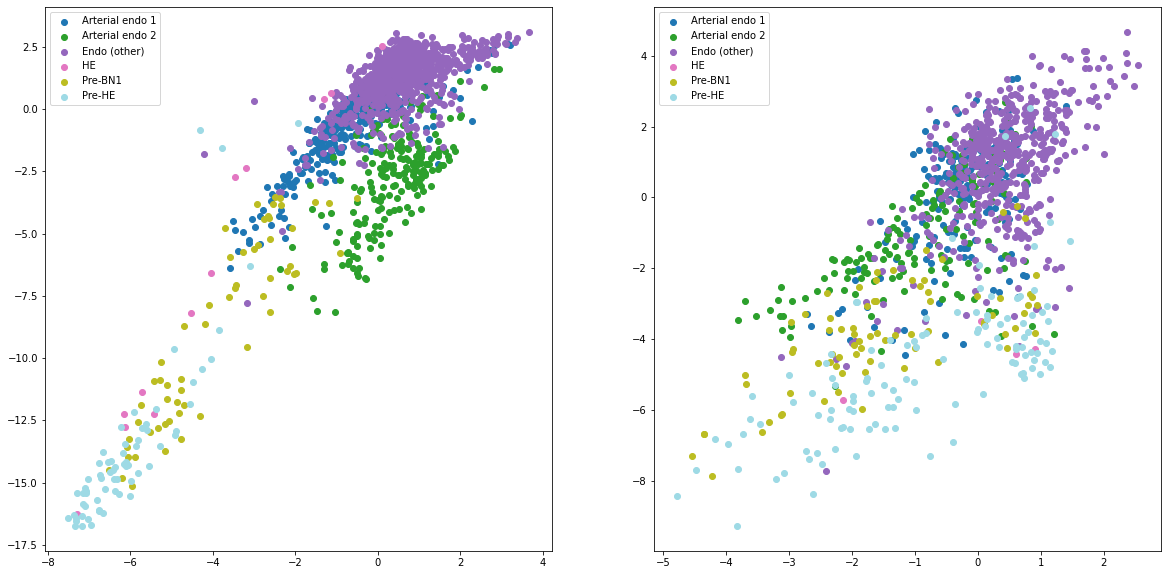

In [16]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = 'result/endo/test/phate_separate_test.pdf')

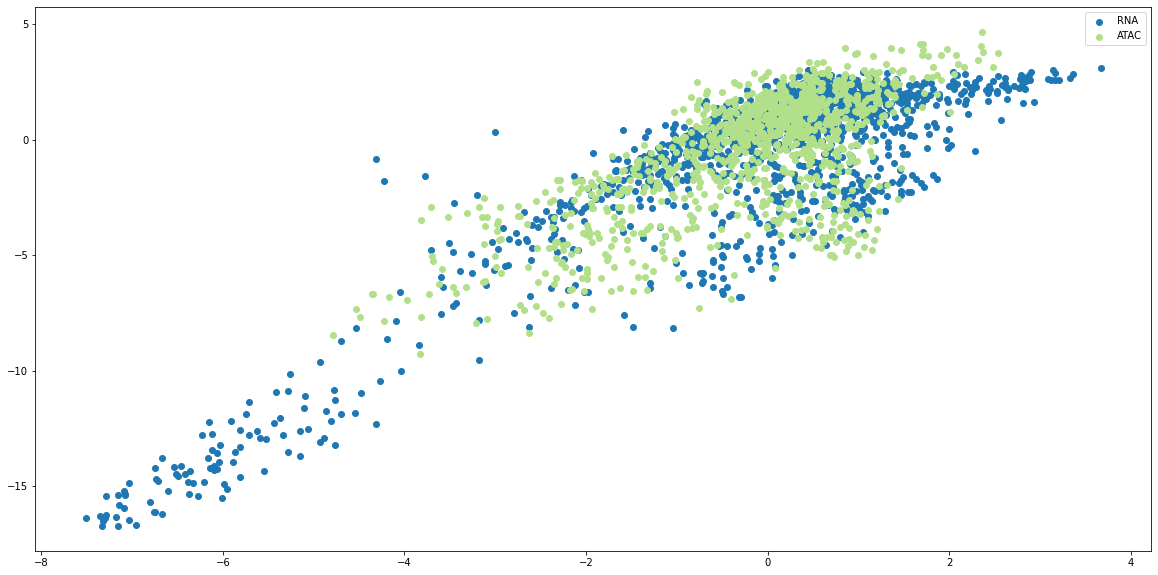

In [17]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = 'result/endo/test/phate_merge_test.pdf')